# Testing and comparing different strategies

The notebook provides testing and comparison between deterministic policies and RL agent strategies among the ErNESTO-gym single agent environment (`MicroGridEnv`). <br>
Refer to the `training.ipynb` notebook to learn how to use ErNESTO-gym to train RL models.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

C:\Users\samue\PycharmProjects\ErNESTO-gym


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from tqdm import tqdm
from collections import OrderedDict
from gymnasium.utils.env_checker import check_env

from ernestogym.envs import MicroGridEnv
from ernestogym.envs.single_agent.utils import parameter_generator

sns.set_style('darkgrid')
plot_colors = sns.color_palette()
sns.set(font_scale=1.5)

In [3]:
alg_color = OrderedDict({
    'random': plot_colors[0],
    'only_market': plot_colors[1],
    'battery_first': plot_colors[2],
    '20-80': plot_colors[3],
    '50-50': plot_colors[4],
    'ppo': plot_colors[5],
    'a2c': plot_colors[6],
    'sac': plot_colors[7]
})

alg_markers = OrderedDict({
    'random': '.',
    'only_market': 'o',
    'battery_first': 'v',
    '20-80': 's',
    '50-50': 'P',
    'ppo': '*',
    'a2c': '+',
    'sac': '<'
})

In [30]:
def plot_rewards(timestamps: list, res: dict, algs: list, reward_type='weighted_reward', sampling_rate=10):
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(12, 12), tight_layout=True)
    
    for i, alg in enumerate(algs):
        trad_list = res[alg][reward_type]['r_trad']   
        op_list = res[alg][reward_type]['r_op']     
        clip_list = res[alg][reward_type]['r_clip']     
        
        ax1.plot(timestamps[::sampling_rate], trad_list[::sampling_rate], label=alg, color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax1.set(xlabel='Samples', ylabel='R_trad')   

        ax2.plot(timestamps[::sampling_rate], op_list[::sampling_rate], label=alg, color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax2.set(xlabel='Samples', ylabel='R_op') 
        
        ax3.plot(timestamps[::sampling_rate], clip_list[::sampling_rate], label=alg, color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax3.set(xlabel='Samples', ylabel='R_clip')
        
        ax1.legend()
    
# def plot_cum_rewards(timestamps: list, res: dict, algs: list, sampling_rate=10, reward_type='weighted_reward'):
#     data = {}
#     fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(12, 12), tight_layout=True)
#     
#     for i, alg in enumerate(algs):
#         means =res[alg][reward_type]['r_trad']
#         ax1.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg, color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
#         ax1.set(xlabel='Samples', ylabel='R_trad')   
#         
#         means = res[alg][reward_type]['r_op']
#         ax2.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg, color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
#         ax2.set(xlabel='Samples', ylabel='R_op') 
#         
#         means = res[alg][reward_type]['r_clip']
#         ax3.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg, color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
#         ax3.set(xlabel='Samples', ylabel='R_clip')
#         
#         ax1.legend()

def plot_cum_rewards(timestamps: list, res: dict, algs: list, sampling_rate=10, reward_type='weighted_reward'):
    data = {}
    fig, ((ax1), (ax2), (ax3), (ax4)) = plt.subplots(4, 1, figsize=(12, 12), tight_layout=True)
    
    for i, alg in enumerate(algs):
        means = res[alg][reward_type]['r_trad']
        ax1.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg, color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax1.set(xlabel='Samples', ylabel='R_trad')   
        
        means = res[alg][reward_type]['r_op']
        ax2.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg, color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax2.set(xlabel='Samples', ylabel='R_op') 
        
        means = res[alg][reward_type]['r_clip']
        ax3.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg, color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax3.set(xlabel='Samples', ylabel='R_clip')
        
        means = [sum(x) for x in zip(res[alg]['weighted_reward']['r_trad'], res[alg]['weighted_reward']['r_op'], res[alg]['weighted_reward']['r_deg'], res[alg]['weighted_reward']['r_clip'])]
        ax4.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg, color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax4.set(xlabel='Samples', ylabel='R_tot')
        
        ax1.legend()

## Environment Information

In [5]:
pack_options = "ernestogym/ernesto/data/battery/pack.yaml"
# ecm = "ernestogym/ernesto/data/battery/models/electrical/thevenin_pack.yaml"
ecm = "ernestogym/ernesto/data/battery/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto/data/battery/models/thermal/r2c_thermal_pack.yaml"
bolun = "ernestogym/ernesto/data/battery/models/aging/bolun_pack.yaml"
# world = "ernestogym/envs/single_agent/world_deg.yaml"
world = "ernestogym/envs/single_agent/world_fading.yaml"

params = parameter_generator(
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True
    
)

In [6]:
# Create environment
env = MicroGridEnv(settings=params)

print('Size of State Space: ', env.observation_space.shape)
print('Observation Space: ', env.spaces.keys())
print('Size of Action Space: ', env.action_space.shape)
print('Min action: ', env.action_space.low)
print('Max action: ', env.action_space.high)
print('Sample State: ', env.observation_space.sample())
print('Sample Action: ', env.action_space.sample())

Size of State Space:  (10,)
Observation Space:  odict_keys(['temperature', 'soc', 'demand', 'generation', 'ask', 'bid', 'sin_day_of_year', 'cos_day_of_year', 'sin_seconds_of_day', 'cos_seconds_of_day'])
Size of Action Space:  (1,)
Min action:  [0.]
Max action:  [1.]
Sample State:  [ 3.1693204e+02  6.2137991e-01  1.2481900e+00  1.7236813e+00
  7.0453817e-01  2.2570267e+00 -7.2436088e-01 -1.8366782e-01
  5.6384194e-01  1.5130150e-02]
Sample Action:  [0.830614]


## Experiment settings

In [7]:
#num_steps = len(env.demand)
num_steps = 100000
timestamps = env.demand.timestamps[:num_steps]
timestamps = [datetime.strptime(time, "%Y-%m-%d %H:%M:%S") for time in timestamps]

comparison_dict = {}

---
## Deterministic policies
Here we can evaluate different rule-based and deterministic policies.
Hereafter we will test:
1. random action policy
2. market-only policy
3. battery-first policy
4. 20/80 policy
5. 50/50 policy

<h3> Random Policy: </h3>
The action is chosen randomly at each decision step.

In [8]:
alg = 'random'
env.reset(options={'eval_profile': '67'})

for i in tqdm(range(num_steps)):
    action = env.action_space.sample()  # Randomly select an action
    obs, reward, terminated, truncated, _ = env.step(action)  # Return observation and reward

profile:  67


100%|██████████| 100000/100000 [01:03<00:00, 1564.77it/s]


In [9]:
comparison_dict[alg] = {}
comparison_dict[alg]['total_reward'] = env.total_reward
comparison_dict[alg]['pure_reward'] = env.pure_reward_list
comparison_dict[alg]['norm_reward'] = env.norm_reward_list
comparison_dict[alg]['weighted_reward'] = env.weighted_reward_list
comparison_dict[alg]['actions'] = [action.tolist() for action in env.action_list]
comparison_dict[alg]['states'] = [state.tolist() for state in env.state_list]

<h3> Only Market Policy: </h3>
The action chosen is always 0, meaning that the battery is never used.

In [10]:
alg = 'only_market'
env.reset(options={'eval_profile': '67'})

for i in tqdm(range(num_steps)):
    action = [0.]  # Only market
    obs, reward, terminated, truncated, _ = env.step(action)  # Return observation and reward

profile:  67


  0%|          | 0/100000 [00:00<?, ?it/s]C:\Users\samue\PycharmProjects\ErNESTO-gym\.venv\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
100%|██████████| 100000/100000 [00:45<00:00, 2182.81it/s]


In [11]:
comparison_dict[alg] = {}
comparison_dict[alg]['total_reward'] = env.total_reward
comparison_dict[alg]['pure_reward'] = env.pure_reward_list
comparison_dict[alg]['norm_reward'] = env.norm_reward_list
comparison_dict[alg]['weighted_reward'] = env.weighted_reward_list
comparison_dict[alg]['actions'] = [action for action in env.action_list]
comparison_dict[alg]['states'] = [state for state in env.state_list]

<h3> Battery First Policy: </h3>
The action chosen is always 1, meaning that the battery is always used before interacting with the market.

In [12]:
alg = 'battery_first'
env.reset(options={'eval_profile': '67'})

for i in tqdm(range(num_steps)):
    action = [1.]  # Only market
    obs, reward, terminated, truncated, _ = env.step(action)  # Return observation and reward

profile:  67


  0%|          | 0/100000 [00:00<?, ?it/s]C:\Users\samue\PycharmProjects\ErNESTO-gym\.venv\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
100%|██████████| 100000/100000 [00:45<00:00, 2177.50it/s]


In [13]:
comparison_dict[alg] = {}
comparison_dict[alg]['total_reward'] = env.total_reward
comparison_dict[alg]['pure_reward'] = env.pure_reward_list
comparison_dict[alg]['norm_reward'] = env.norm_reward_list
comparison_dict[alg]['weighted_reward'] = env.weighted_reward_list
comparison_dict[alg]['actions'] = [action for action in env.action_list]
comparison_dict[alg]['states'] = [state for state in env.state_list]

<h3> 20-80 Policy: </h3>
The action chosen is always 0.2, meaning that the battery is used only for the 20% of the margin energy.

In [14]:
alg = '20-80'
env.reset(options={'eval_profile': '67'})

for i in tqdm(range(num_steps)):
    action = [0.2]  # Only market
    obs, reward, terminated, truncated, _ = env.step(action)  # Return observation and reward

profile:  67


  0%|          | 0/100000 [00:00<?, ?it/s]C:\Users\samue\PycharmProjects\ErNESTO-gym\.venv\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
100%|██████████| 100000/100000 [00:49<00:00, 2036.79it/s]


In [15]:
comparison_dict[alg] = {}
comparison_dict[alg]['total_reward'] = env.total_reward
comparison_dict[alg]['pure_reward'] = env.pure_reward_list
comparison_dict[alg]['norm_reward'] = env.norm_reward_list
comparison_dict[alg]['weighted_reward'] = env.weighted_reward_list
comparison_dict[alg]['actions'] = [action for action in env.action_list]
comparison_dict[alg]['states'] = [state for state in env.state_list]

<h3> 50-50 Policy: </h3>
The action chosen is always 0.5, meaning that the battery is never used.

In [16]:
alg = '50-50'
env.reset(options={'eval_profile': '67'})

for i in tqdm(range(num_steps)):
    action = [0.5]  # Only market
    obs, reward, terminated, truncated, _ = env.step(action)  # Return observation and reward

profile:  67


  0%|          | 0/100000 [00:00<?, ?it/s]C:\Users\samue\PycharmProjects\ErNESTO-gym\.venv\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
100%|██████████| 100000/100000 [00:46<00:00, 2142.99it/s]


In [17]:
comparison_dict[alg] = {}
comparison_dict[alg]['total_reward'] = env.total_reward
comparison_dict[alg]['pure_reward'] = env.pure_reward_list
comparison_dict[alg]['norm_reward'] = env.norm_reward_list
comparison_dict[alg]['weighted_reward'] = env.weighted_reward_list
comparison_dict[alg]['actions'] = [action for action in env.action_list]
comparison_dict[alg]['states'] = [state for state in env.state_list]

---
## Reinforcement Learning Agents 

<h3>PPO Agent</h3>

In [18]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy

In [19]:
model = PPO.load("examples/single_agent/models/ppo_100000_steps.zip", env=env)
    
alg = 'ppo'    
actions = [] 
vec_env = model.get_env()
vec_env.set_options({'eval_profile': '67'})
obs = vec_env.reset()
for i in tqdm(range(num_steps)):
    action, _states = model.predict(obs)
    actions.append(action)
    obs, rewards, dones, info = vec_env.step(action)

profile:  67


100%|██████████| 100000/100000 [01:16<00:00, 1306.51it/s]


In [20]:
comparison_dict[alg] = {}
comparison_dict[alg]['total_reward'] = env.total_reward
comparison_dict[alg]['pure_reward'] = env.pure_reward_list
comparison_dict[alg]['norm_reward'] = env.norm_reward_list
comparison_dict[alg]['weighted_reward'] = env.weighted_reward_list
comparison_dict[alg]['actions'] = [action for action in env.action_list]
comparison_dict[alg]['states'] = [state for state in env.state_list]

<h3>A2C Agent</h3>

In [21]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy

In [22]:
model = PPO.load("examples/single_agent/models/a2c_100000_steps.zip", env=env)
    
alg = 'a2c'    
actions = [] 
vec_env = model.get_env()
vec_env.set_options({'eval_profile': '67'})
obs = vec_env.reset()
for i in tqdm(range(num_steps)):
    action, _states = model.predict(obs)
    actions.append(action)
    obs, rewards, dones, info = vec_env.step(action)

profile:  67


100%|██████████| 100000/100000 [01:14<00:00, 1340.91it/s]


In [23]:
comparison_dict[alg] = {}
comparison_dict[alg]['total_reward'] = env.total_reward
comparison_dict[alg]['pure_reward'] = env.pure_reward_list
comparison_dict[alg]['norm_reward'] = env.norm_reward_list
comparison_dict[alg]['weighted_reward'] = env.weighted_reward_list
comparison_dict[alg]['actions'] = [action for action in env.action_list]
comparison_dict[alg]['states'] = [state for state in env.state_list]

## Comparison between the different baselines

In [41]:
algs_to_compare = ['random', 'only_market', 'battery_first', '20-80', '50-50', 'ppo', 'a2c']
# algs_to_compare = ['only_market', 'battery_first', 'ppo', 'a2c']

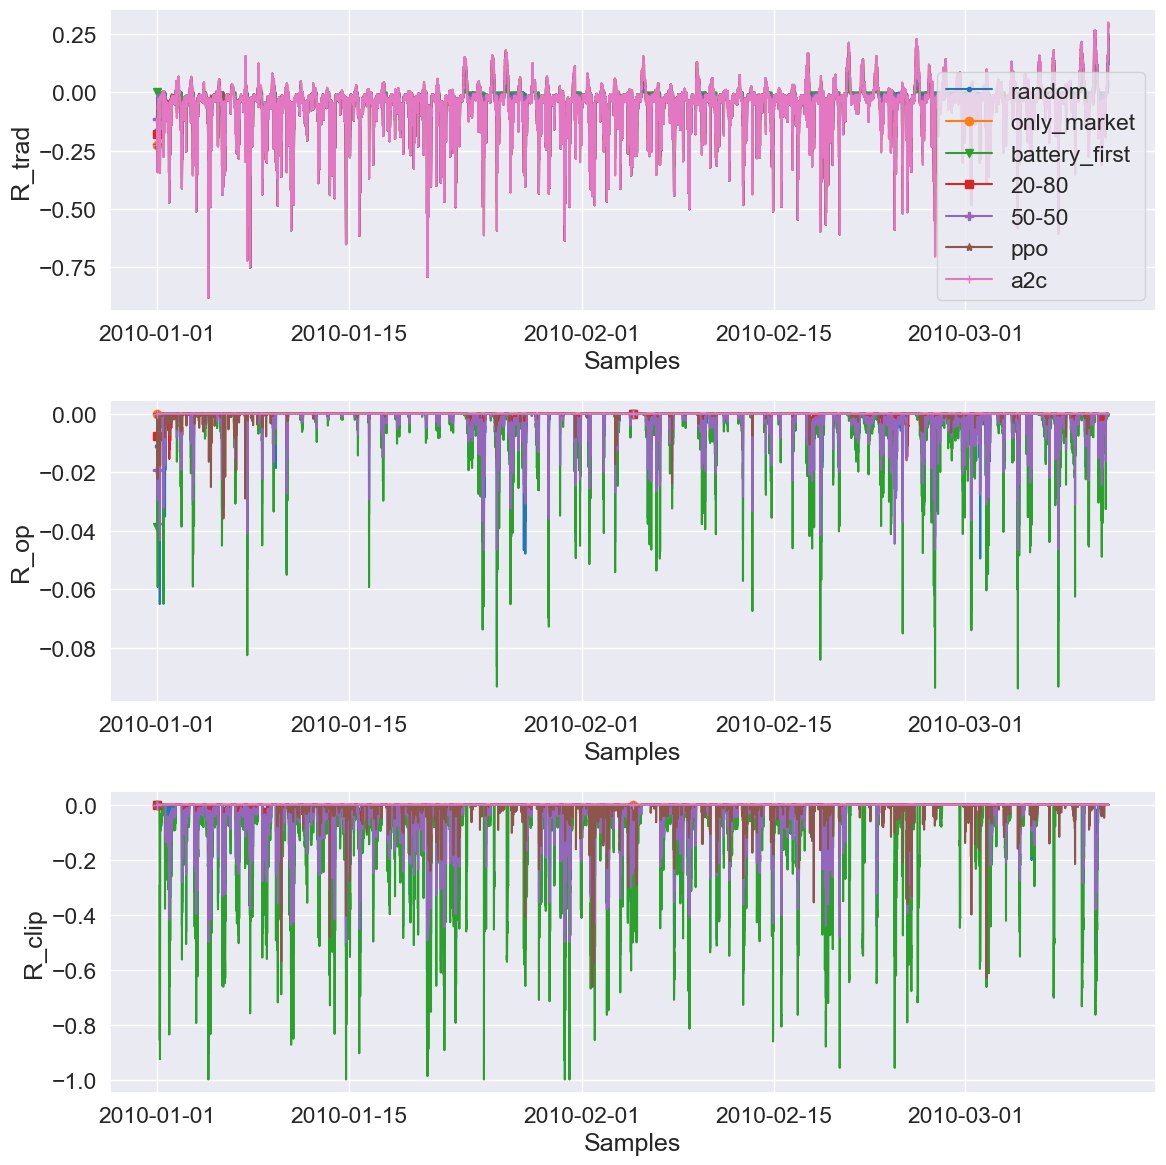

In [42]:
plot_rewards(timestamps=timestamps, res=comparison_dict, algs=algs_to_compare)

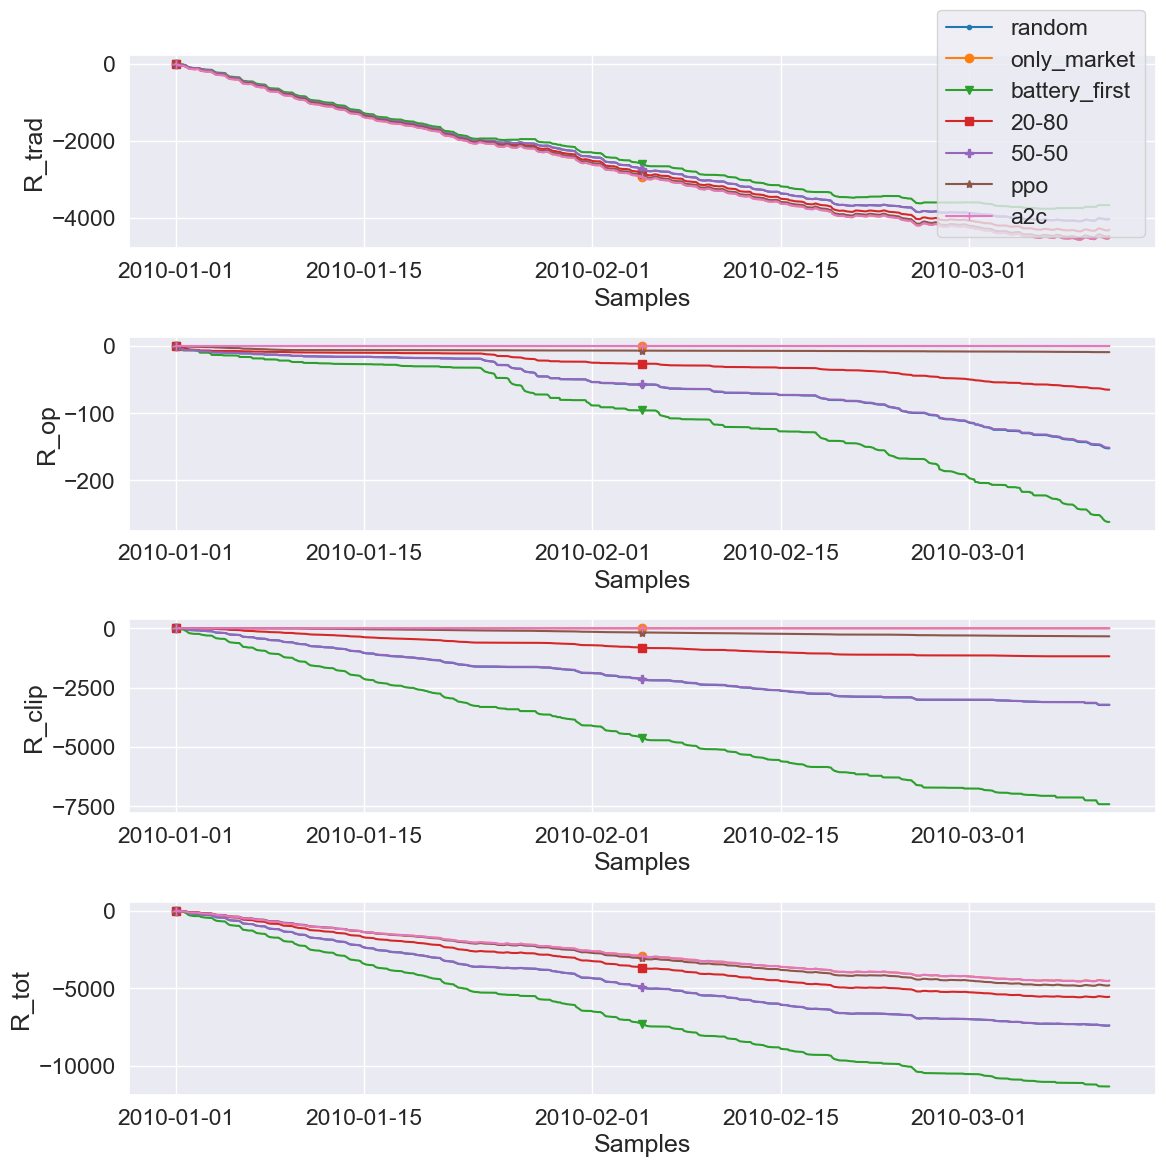

In [43]:
plot_cum_rewards(timestamps=timestamps, res=comparison_dict, algs=algs_to_compare)